Based on https://github.com/UNC-optics/Introduction-to-holography/blob/master/Demo_1_Wave_Propagation.m

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from skimage import io, transform

In [5]:
def get_image(x_axis_size, y_axis_size):
    url = "https://raw.githubusercontent.com/UNC-optics/Introduction-to-holography/master/Image1.jpg"

    data = io.imread( url ).astype( float )
    data = np.mean( data, 2 )

    data = data - np.min( data )
    data = data / np.max( data )
    data = 1. - data

    data = data / np.sum( data )

    data = transform.resize( data, ( x_axis_size, y_axis_size ) )

    return -data

def show_results( Intensity, Amplitude, Phase, z ):
    fig, axs = plt.subplots( 1, 3, figsize=( 9, 5 ), sharey=True, sharex=True )

    axs[ 0 ].imshow( Intensity, cmap='gray' )
    axs[ 0 ].set_xlabel( 'X [mm]' ) 
    axs[ 0 ].set_ylabel( 'Y [mm]' )
    axs[ 0 ].set_title( f'Intensity at z={z}' )

    axs[ 1 ].imshow( Amplitude, cmap='gray' )
    axs[ 1 ].set_xlabel( 'X [mm]' ) 
    axs[ 1 ].set_ylabel( 'Y [mm]' )
    axs[ 1 ].set_title( f'Amplitude at z={z}' ) 

    axs[ 2 ].imshow( Phase, cmap='gray' )
    axs[ 2 ].set_xlabel( 'X [mm]' ) 
    axs[ 2 ].set_ylabel( 'Y [mm]' )
    axs[ 2 ].set_title( f'Phase at z={z}' )  

propagation_distances_meters = np.linspace(0, 0.010, 20) # 20 equally spaced numbers between 0.010 and 20 inclusive


# Fresnel Diffraction

Fresnel diffraction models how a planar light wave hitting an aperture of arbitrary shape diffuses over a screen placed at a distant $z$ from that aperture.
It takes advantage of the Huygens Principle whereby an aperture can be modelled as a number of point sources each emitting a spherical wave. The intensity of the light hitting any point $(x, y, z)$ on the screen is the sum of the contributions from each of these point sources:
\begin{equation}
A(x, y, z) = \frac{e^{izk}}{iz\lambda}\int\int_{-\infty}^{\infty}A(x^{\prime}, y^{\prime}, 0) e^{\frac{ik}{2z}[(x-x^{\prime})^2 + (y - y^{\prime})^2]}dx^{\prime}dy^{\prime}
\end{equation}
where $(x^{\prime}, y^{\prime}, 0)$ is a point on the aperture and $k=\frac{2\pi}{\lambda}$ with $\lambda$ being the wave length.  
The following implementation takes advantage of the observation that the above can be expressed in terms of a [convolution](https://en.wikipedia.org/wiki/Convolution) operation.  
Let $G(x, y, z) = e^{\frac{ik}{2z}(x^2 + y^2)}$, then the Fresnel diffraction may be rewritten as:
\begin{equation}
A(x, y, z) = \frac{e^{izk}}{iz\lambda} (A*G)(x, y, z)
\end{equation}
The convolution operation $*$ can be turned into a multiplication by applying the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem) and switching from the spatial domain to the frequency domain through the application of a *Fourier Transform* $\mathcal{F}$ on both $A$ and $G$. Therefore the final expression becomes:
\begin{equation}
A(x, y, z) = \frac{e^{izk}}{iz\lambda} \mathcal{F}^{-1}(\mathcal{F}(A)\cdot\mathcal{F}(G))
\end{equation}
where $\mathcal{F}^{-1}$ is the $inverse$ Fourier Transform required in order to get back to the spatial domain.  
Note that after fully computing the inverse transform, the denominator $iz\lambda$ cancels out leaving only the pure $phase$ term $e^{izk}$ which can be disregarded if all we care about is the field value (i.e. the amplitudes).


In [121]:
def get_angle_grid(image_size, pixel_size):
    M, N = (image_size, image_size)

    UY = np.arange( M )
    UY = UY - np.mean( UY )

    UY -= 1 if M%2 == 1 else .5

    UX = np.arange( N )
    UX = UX - np.mean( UX )

    UX -= 1 if N%2 == 1 else .5

    x, y = np.meshgrid( UX, UY )
    
    # in a discrete fourier transform setting
    # the following are the fractional angles 
    # in the complex circle representing each frequency
    kx = x / pixel_size / N 
    ky = y / pixel_size / M

    return kx, ky

def fresnelDiffraction( amplitudes, wavelength, z, kx, ky):

    H = np.exp( -1j * np.pi * wavelength * z * ( kx**2 + ky**2 ) )

    H = np.fft.fftshift( H )

    objFT = np.fft.fft2( amplitudes )

    field = np.fft.ifft2( objFT * H )

    return field

def score(amplitudes, wavelength, z, kx, ky):
    H = np.exp( -1j * np.pi * wavelength * z * ( kx**2 + ky**2 ) )
    # H = np.cos(np.pi * wavelength * z * ( kx**2 + ky**2 )) + (-1j * np.sin(np.pi * wavelength * z * ( kx**2 + ky**2 )))
    # H = np.cos(np.pi * wavelength * z * ( kx**2 + ky**2 ))
    H = np.fft.fftshift( H )

    objFT = np.fft.fft2( amplitudes )

    new_field = np.fft.ifft2( objFT * H )
    amplitude_at_z = np.abs(new_field)

    return np.sum(amplitude_at_z)


-0.09999999999999999
-0.09
-0.11
-0.08
-0.12
-0.060000000000000005
-0.14
-0.05
-0.15000000000000002
-0.17
-0.03
-0.04
-0.18000000000000002
-0.2
-0.02
-0.16
-0.13
-0.01
-0.19
-0.06999999999999999


/home/vscode/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


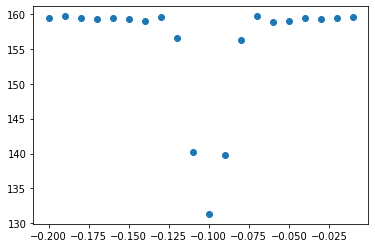

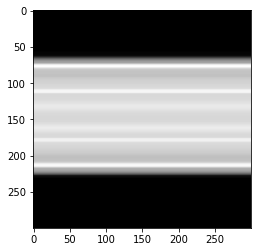

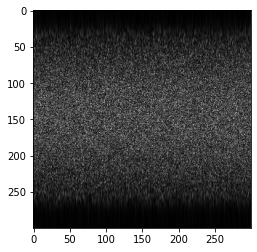

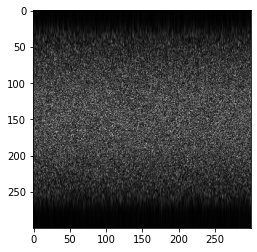

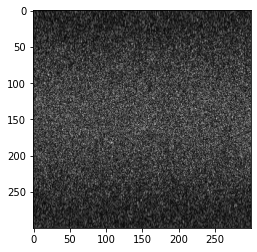

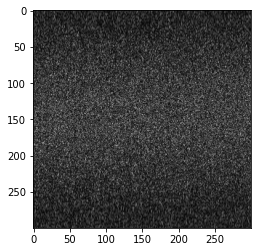

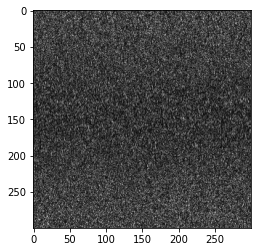

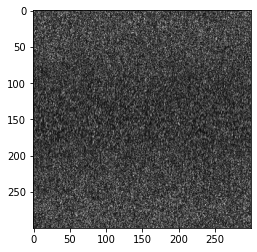

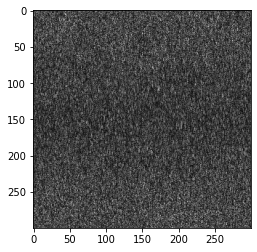

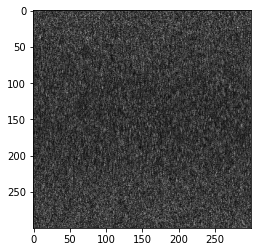

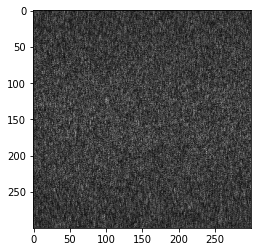

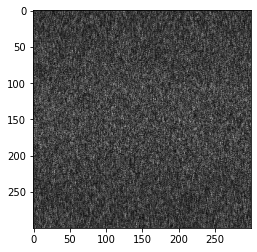

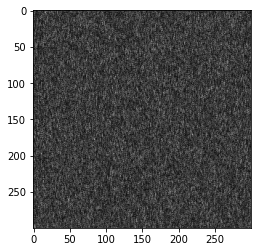

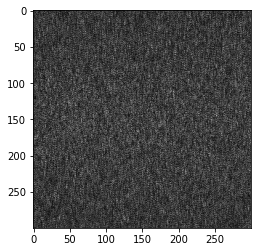

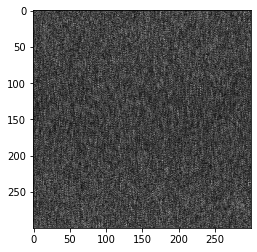

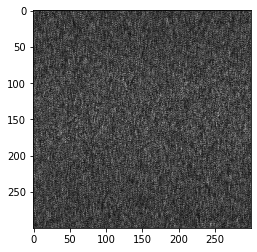

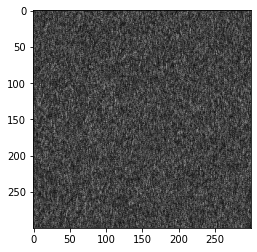

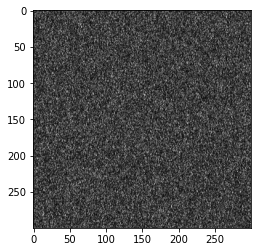

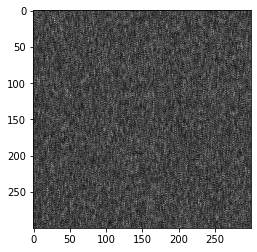

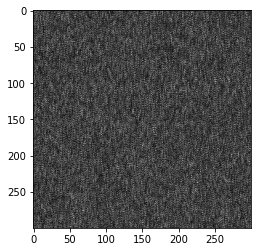

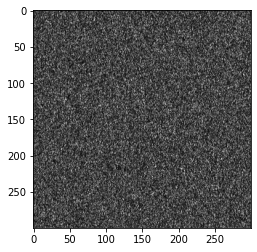

In [126]:
wavelength = 1.0e-6 # meters (1.0 * 10^-6 = 0.0000010) AKA lambda
pixel_size = 10.0e-6 # meters
x_axis_size = 300
y_axis_size = 300

image = get_image(x_axis_size, y_axis_size)
flatImage = []
for i in range(300):
    mean = np.mean(image[i])
    for j in range(300):
        image[i][j] = mean

amplitude = -np.sqrt( image, dtype=complex )
phase = 2. * np.pi * np.random.rand( x_axis_size, y_axis_size )
complex_field = amplitude * np.exp(1j * phase)

kx, ky = get_angle_grid(x_axis_size, pixel_size)
shifted_complex_filed = fresnelDiffraction(complex_field, wavelength, 0.1, kx, ky)

def test_z(z, complex_field, wavelength, kx, ky):
    new_field = fresnelDiffraction(complex_field, wavelength, z, kx, ky)
    amplitude_at_z = np.abs(new_field)
    print(z)
    plt.figure()
    plt.imshow(amplitude_at_z, cmap='gray' )

# test_z(-0.1, shifted_complex_filed, wavelength, kx, ky)
# current_score = score(shifted_complex_filed, wavelength, -0.1, kx, ky)

# test_z(-4.6, shifted_complex_filed, wavelength, kx, ky)

scores = []
# for i in range(0, 200):
#     z = (-0.001 * i) - 0.001
for i in range(0, 20):
    z = (-0.01 * i) - 0.01
    current_score = score(shifted_complex_filed, wavelength, z, kx, ky)
    scores.append((z, current_score))

min_scores = sorted(scores, key=lambda x: x[1])[:20]

xs = [i for i,_ in scores]
ys = [i for _,i in scores]
plt.scatter(xs, ys)

for z, s in min_scores:
    test_z(z, shifted_complex_filed, wavelength, kx, ky)